In [1]:
# update the polars package - optional
# !pip install --upgrade polars

In [2]:
import polars as pl

# Add the hamilton module to your path - optinal
# project_dir = "### ADD PATH HERE ###"
# sys.path.append(project_dir)

from hamilton import driver
from hamilton.io.materialization import to
from hamilton.plugins import h_polars

In [3]:
# We use the autoreload extension that comes with ipython to automatically reload modules when
# the code in them changes.

# import the jupyter extension
%load_ext autoreload
# set it to only reload the modules imported
%autoreload 1

In [4]:
%%writefile spend_calculations.py
# Define your new Hamilton functions.
# The %%writefile magic command creates a new Python module with the functions below.
# We will import this later and pass it into our Driver.

import polars as pl

# Look at `my_functions` to see how these functions connect.
def avg_3wk_spend(spend: pl.Series) -> pl.Series:
    """Rolling 3 week average spend."""
    return spend.rolling_mean(3)


def spend_per_signup(spend: pl.Series, signups: pl.Series) -> pl.Series:
    """The cost per signup in relation to spend."""
    return spend / signups


def spend_mean(spend: pl.Series) -> float:
    """Shows function creating a scalar. In this case it computes the mean of the entire column."""
    return spend.mean()


def spend_zero_mean(spend: pl.Series, spend_mean: float) -> pl.Series:
    """Shows function that takes a scalar. In this case to zero mean spend."""
    return spend - spend_mean


def spend_std_dev(spend: pl.Series) -> float:
    """Function that computes the standard deviation of the spend column."""
    return spend.std()


def spend_zero_mean_unit_variance(spend_zero_mean: pl.Series, spend_std_dev: float) -> pl.Series:
    """Function showing one way to make spend have zero mean and unit variance."""
    return spend_zero_mean / spend_std_dev

Overwriting spend_calculations.py


In [5]:
initial_columns = {  # load from actuals or wherever -- this is our initial data we use as input.
    # Note: these values don't have to be all series, they could be a scalar.
    "signups": pl.Series([1, 10, 50, 100, 200, 400]),
    "spend": pl.Series([10, 10, 20, 40, 40, 50]),
}

In [6]:
%aimport spend_calculations

df_builder = h_polars.PolarsDataFrameResult()
dr = driver.Driver({}, spend_calculations)  # can pass in multiple modules

Note: Hamilton collects completely anonymous data about usage. This will help us improve Hamilton over time. See https://github.com/dagworks-inc/hamilton#usage-analytics--data-privacy for details.


In [7]:
# we need to specify what we want in the final dataframe. These can be string names, or function references.
output_columns = [
    "spend",
    "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

In [8]:
# pass

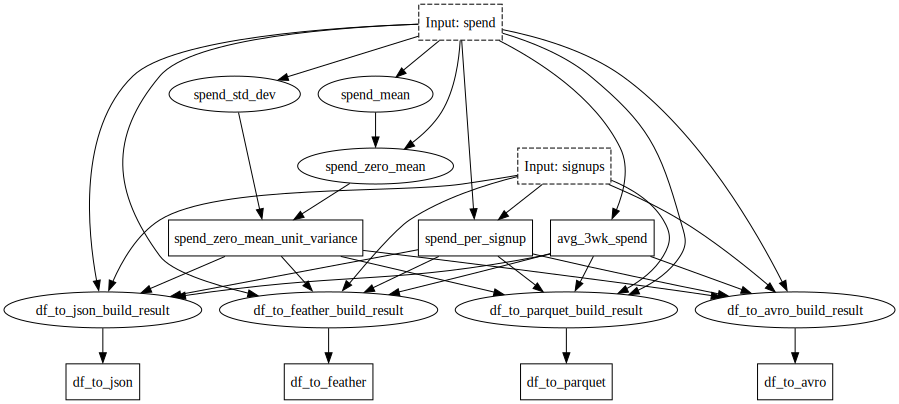

In [10]:
materializers = [
    # materialize the dataframe to a parquet file
    to.parquet(
        dependencies=output_columns,
        id="df_to_parquet",
        file="./df.parquet",
        combine=df_builder,
    ),
    # materialize the dataframe to a feather file
    to.feather(
        dependencies=output_columns,
        id="df_to_feather",
        file="./df.feather",
        combine=df_builder,
    ),
    # materialize the dataframe to a json file
    to.json(
        dependencies=output_columns,
        id="df_to_json",
        file="./df.json",
        combine=df_builder,
    ),
    # materialize the dataframe to an avro file
    to.avro(
        dependencies=output_columns,
        id="df_to_avro",
        file="./df.avro",
        combine=df_builder,
    ),
]
# Visualize what is happening
dr.visualize_materialization(
    *materializers,
    additional_vars=output_columns,
    inputs=initial_columns,
)

In [11]:
# Materialize a result, i.e. execute the DAG!
materialization_results, additional_outputs = dr.materialize(
    *materializers,
    additional_vars=[
        "df_to_parquet_build_result",
        "df_to_feather_build_result",
        "df_to_json_build_result",
        "df_to_avro_build_result",
    ],  # because combine is used, we can get that result here.
    inputs=initial_columns,
)

In [12]:
materialization_results

{'df_to_parquet': {'size': 1605,
  'path': './df.parquet',
  'last_modified': 1696820306.5002773,
  'timestamp': 1696800506.500361},
 'df_to_feather': {'size': 1696,
  'path': './df.feather',
  'last_modified': 1696820306.5006804,
  'timestamp': 1696800506.500732},
 'df_to_json': {'size': 657,
  'path': './df.json',
  'last_modified': 1696820306.5011163,
  'timestamp': 1696800506.501182},
 'df_to_avro': {'size': 517,
  'path': './df.avro',
  'last_modified': 1696820306.5013201,
  'timestamp': 1696800506.501356}}

In [13]:
additional_outputs["df_to_parquet_build_result"]

spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
i64,i64,f64,f64,f64
10,1,null,10.0,-1.064405
10,10,null,1.0,-1.064405
20,50,13.333333,0.4,-0.483821
40,100,23.333333,0.4,0.677349
40,200,33.333333,0.2,0.677349
50,400,43.333333,0.125,1.257934


In [14]:
additional_outputs["df_to_feather_build_result"]

spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
i64,i64,f64,f64,f64
10,1,null,10.0,-1.064405
10,10,null,1.0,-1.064405
20,50,13.333333,0.4,-0.483821
40,100,23.333333,0.4,0.677349
40,200,33.333333,0.2,0.677349
50,400,43.333333,0.125,1.257934


In [15]:
additional_outputs["df_to_json_build_result"]

spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
i64,i64,f64,f64,f64
10,1,null,10.0,-1.064405
10,10,null,1.0,-1.064405
20,50,13.333333,0.4,-0.483821
40,100,23.333333,0.4,0.677349
40,200,33.333333,0.2,0.677349
50,400,43.333333,0.125,1.257934


In [16]:
additional_outputs["df_to_avro_build_result"]

spend,signups,avg_3wk_spend,spend_per_signup,spend_zero_mean_unit_variance
i64,i64,f64,f64,f64
10,1,null,10.0,-1.064405
10,10,null,1.0,-1.064405
20,50,13.333333,0.4,-0.483821
40,100,23.333333,0.4,0.677349
40,200,33.333333,0.2,0.677349
50,400,43.333333,0.125,1.257934
